# Using gammapy to simulate GW observations

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from typing import List


# %matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
)
from regions import CircleSkyRegion

from pathlib import Path
import seaborn as sns
import pandas as pd

import warnings
import logging
from contextlib import contextmanager

from gravitational_wave_toy.ctairf import IRFHouse, IRF, Duration


sns.set()

In [2]:
@contextmanager
def suppress_warnings_and_logs():
    logging.disable(logging.WARNING)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield
    logging.disable(logging.NOTSET)

In [3]:
def gamma_sens(
    irf: str | Path,
    observatory: str,
    duration: int,
    radius: float,
    e_min: float,
    e_max: float,
    model: SpectralModel | str | None = None,
    source_ra: float = 83.6331,
    source_dec: float = 22.0145,
    sigma: float = 5,
    bins: int = 1,
    offset: float = 0.0,
    acceptance: float = 1,
    acceptance_off: float = 5,
    bkg_syst_fraction: float = 0.05,
):
    """
    Calculate the integral sensitivity for a given set of parameters.

    Parameters
    ----------
    irf : str
        IRF to use
    observatory : str
        Observatory name [see `~gammapy.data.observatory_locations`]
    duration : int
        Observation duration in hours
    radius : float
        On region radius in degrees
    e_min : float
        Minimum energy in TeV
    e_max : float
        Maximum energy in TeV
    sigma : float
        Minimum significance
    bins : int
        Number of energy bins
    offset : float
        Offset in degrees
    acceptance : float
        On region acceptance
    acceptance_off : float
        Off region acceptance
    bkg_syst_fraction : float
        Fraction of background counts above which the number of gamma-rays is

    Returns
    -------
    sensitivity : `~astropy.units.Quantity`
        Integral sensitivity in units of cm^-2 s^-1
    """
    # check that IRF file exists
    irf = Path(irf)
    if not irf.exists():
        raise FileNotFoundError(f"IRF file not found: {irf}")

    # Define energy axis
    energy_axis = MapAxis.from_energy_bounds(
        e_min, e_max, bins, unit=u.TeV, name="energy"
    )

    energy_axis_true = MapAxis.from_energy_bounds(
        "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
    )

    # Define region
    pointing = SkyCoord(source_ra, source_dec, unit="deg", frame="icrs")
    offset_pointing = SkyCoord(source_ra, source_dec + offset, unit="deg", frame="icrs")
    region = CircleSkyRegion(center=offset_pointing, radius=radius * u.deg)
    geom = RegionGeom.create(region, axes=[energy_axis])

    # pointing = SkyCoord(0, 0, unit="deg", frame="icrs")
    # geom = RegionGeom.create(f"icrs;circle(0, {offset}, {radius})", axes=[energy_axis])

    # Define empty dataset
    empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

    # define power law dataset
    if model == "powerlaw":
        model = PowerLawSpectralModel(
            index=2.1, amplitude="5.7e-13 cm-2 s-1 TeV-1", reference="1 TeV"
        )

    # Load IRFs
    irfs = load_irf_dict_from_file(irf)

    # Define observation
    location = observatory_locations[observatory]
    # pointing = SkyCoord("0 deg", "0 deg")
    livetime = duration * u.s
    obs = Observation.create(
        pointing=pointing, irfs=irfs, livetime=livetime, location=location
    )

    # Create dataset
    spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
    dataset = spectrum_maker.run(empty_dataset, obs)

    ## Correct for energy dependent region size
    # Define containment
    containment = 0.68

    # correct exposure
    dataset.exposure *= containment

    # Define on region radius
    on_radii = obs.psf.containment_radius(
        energy_true=energy_axis.center, offset=offset * u.deg, fraction=containment
    )

    factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
    dataset.background *= factor.value.reshape((-1, 1, 1))

    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=dataset, acceptance=acceptance, acceptance_off=acceptance_off
    )

    ## Calculate sensitivity
    sensitivity_estimator = SensitivityEstimator(
        spectrum=model,
        gamma_min=5,
        n_sigma=sigma,
        bkg_syst_fraction=bkg_syst_fraction,
    )

    sensitivity_table = sensitivity_estimator.run(dataset_on_off)

    return sensitivity_table

In [4]:
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

irf1 = house.get_irf(
    site="south",
    configuration="omega",
    zenith=20,
    duration=1800,
    azimuth="average",
    version="prod5-v0.2",
)

irf2 = house.get_irf(
    site="south",
    configuration="omega",
    zenith=40,
    duration=1800,
    azimuth="average",
    version="prod5-v0.2",
)

irf3 = house.get_irf(
    site="south",
    configuration="omega",
    zenith=60,
    duration=1800,
    azimuth="average",
    version="prod5-v0.2",
)

In [5]:
res = gamma_sens(
    irf=irf3.filepath,
    observatory="cta_south",
    duration=600,
    radius=3.0,
    e_min=0.03,
    e_max=10,
    sigma=5,
    bins=1,
    offset=0.0,
)

/Users/jarred/Documents/Work/gravitational_wave_toy/.venv/lib/python3.10/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


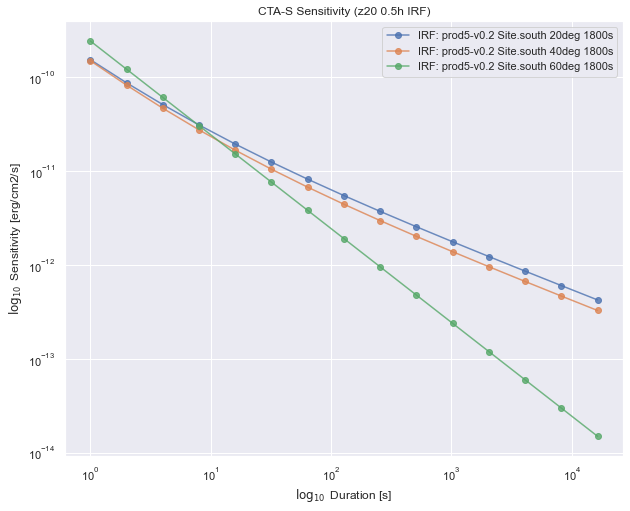

In [6]:
with suppress_warnings_and_logs():
    fig = plt.figure(figsize=(10, 8))  # Move this line outside of the loop

    for irf in [irf1, irf2, irf3]:
        times = [2**i for i in range(0, 15)]
        res = []

        for duration in times:
            sens = gamma_sens(
                irf=irf.filepath,
                observatory="cta_south",
                duration=duration,
                radius=3.0,
                e_min=0.03,
                e_max=10,
                sigma=5,
                bins=1,
                offset=0.0,
            )

            res.append(sens["e2dnde"][0])

        plt.plot(
            times,
            res,
            marker="o",
            markersize=6,
            label=f"IRF: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
            alpha=0.8,
        )

    plt.yscale("log")
    plt.xscale("log")
    plt.title("CTA-S Sensitivity (z20 0.5h IRF)")
    plt.xlabel("$\log_{10}$ Duration [s]")
    plt.ylabel("$\log_{10}$ Sensitivity [erg/cm2/s]")
    plt.legend()  # Add this line to show the labels for each plot
    plt.show()

# Comparison with ctools
-- original code --

In [11]:
def get_emin(zenith: int):
    if zenith == 20:
        return 0.03
    elif zenith == 40:
        return 0.04
    elif zenith == 60:
        return 0.11
    else:
        raise ValueError("Zenith must be 20, 40 or 60")

In [17]:
def plot_sensitivity(irfs: List[IRF], site: str, configuration: str, version: str, model: SpectralModel | None = None):
    """
    Plot the sensitivity for different IRFs.

    Parameters
    ----------
    irfs : List
        List of IRFs to plot
    site : str
        Site name
    configuration : str
        Configuration name
    version : str
        Version name
    """
    # Define a list of nicer colors for the plots
    colors = sns.color_palette("Set1", n_colors=len(irfs))

    with suppress_warnings_and_logs():
        fig = plt.figure(figsize=(10, 8))  # Move this line outside of the loop
        tables = {}

        for i, irf in enumerate(irfs):
            times = [2**i for i in range(0, 15)]
            res = []
            tables[irf.zenith] = {}

            for duration in tqdm(
                times,
                desc=f"Processing IRF: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
            ):
                s = gamma_sens(
                    irf=irf.filepath,
                    observatory=f"cta_{irf.site.name}",
                    duration=duration,
                    model=model,
                    radius=3.0,
                    e_min=get_emin(irf.zenith),
                    e_max=10,
                    sigma=5,
                    bins=1,
                    offset=0.0,
                )

                tables[irf.zenith][duration] = s
                res.append(s["e2dnde"][0])
                # res.append(s.value)

            plt.plot(
                times,
                res,
                marker="o",
                markersize=6,
                label=f"gammapy: {irf.version} {irf.site} {irf.zenith}deg {irf.duration}s",
                alpha=0.8,
                color=colors[i],  # Use the nicer color for each plot within the loop
            )

            # plot grbsens sensitivity too
            grbsens_dir = Path(
                "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration"
            )
            file = (
                grbsens_dir
                / f"grbsens-5.0sigma_t1s-t16384s_irf-{irf.site.name.capitalize()}_z{irf.zenith}_0.5h.txt"
            )
            cols = [
                "duration",
                "crab_flux",
                "photon_flux",
                "energy_flux",
                "sensitivity",
            ]

            curve = pd.read_csv(file, sep="\t", comment="#", names=cols)

            plt.plot(
                curve["duration"],
                curve["sensitivity"],
                marker="x",
                markersize=6,
                label=f"grbsens: {irf.version} {irf.site} {irf.zenith}deg {round(irf.duration / 3600, 1)}h",
                alpha=0.8,
                color=colors[i],  # Use the nicer color for each plot within the loop
            )

        plt.yscale("log")
        plt.xscale("log")
        plt.title(
            f"CTA-{site.capitalize()} {configuration} config sensitivity ({version} 0.5h IRF)"
        )
        plt.xlabel("$\log_{10}$ Duration [s]")
        plt.ylabel("$\log_{{10}}$ Sensitivity [erg/cm2/s]")
        plt.legend()  # Add this line to show the labels for each plot
        plt.show()

    return tables

## South-alpha comparison

Processing IRF: prod5-v0.1 Site.south 20deg 1800s: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]
Processing IRF: prod5-v0.1 Site.south 40deg 1800s: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
Processing IRF: prod5-v0.1 Site.south 60deg 1800s: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


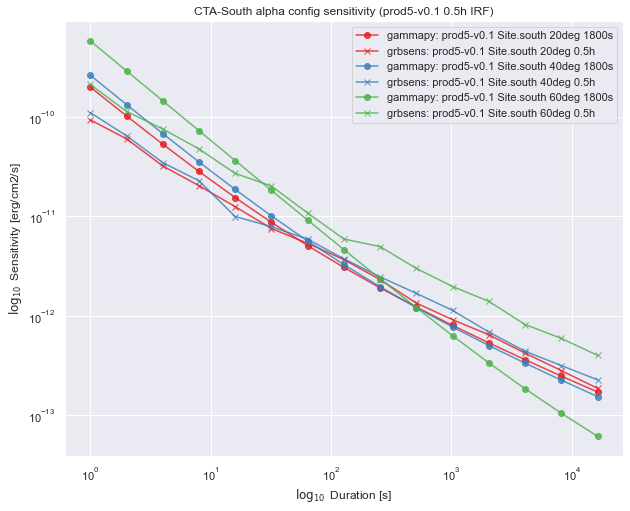

In [160]:
site = "south"
configuration = "alpha"
version = "prod5-v0.1"

irfs = [
    house.get_irf(
        site=site,
        configuration=configuration,
        zenith=z,
        duration=1800,
        azimuth="average",
        version=version,
    )
    for z in [20, 40, 60]
]

tables = plot_sensitivity(irfs, site, configuration, version)

## South omega comarison

Processing IRF: prod3b-v2 Site.south 60deg 1800s: 100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


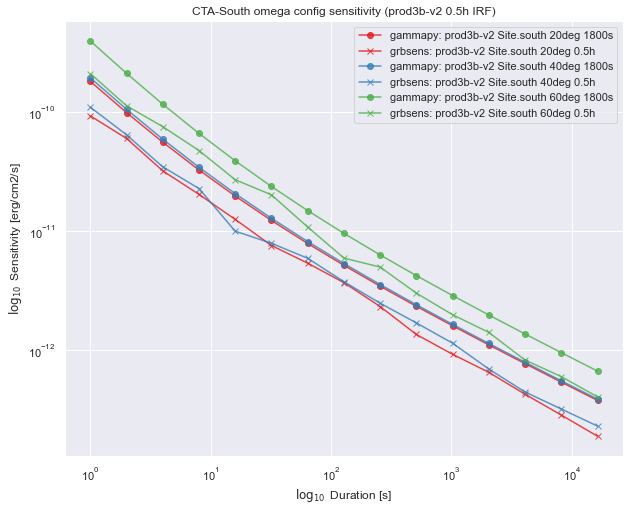

In [159]:
site = "south"
configuration = "omega"
version = "prod3b-v2"

irfs = [
    house.get_irf(
        site=site,
        configuration=configuration,
        zenith=z,
        duration=1800,
        azimuth="average",
        version=version,
    )
    for z in [20, 40, 60]
]

tables = plot_sensitivity(irfs, site, configuration, version)

## North-alpha comparison

Processing IRF: prod5-v0.1 Site.north 20deg 1800s: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]
Processing IRF: prod5-v0.1 Site.north 40deg 1800s: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]
Processing IRF: prod5-v0.1 Site.north 60deg 1800s: 100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


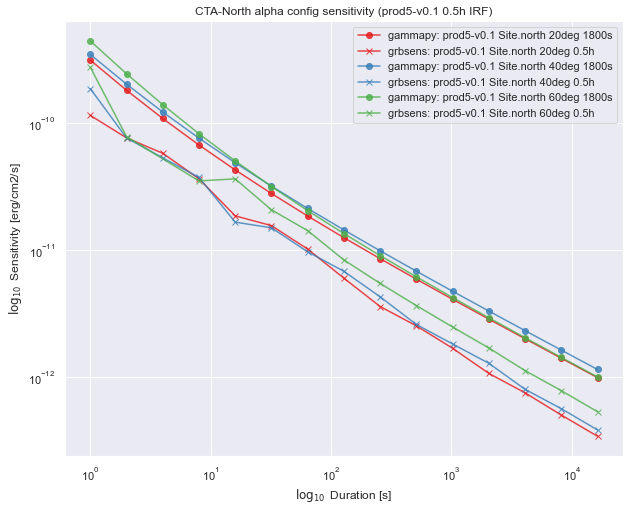

In [161]:
site = "north"
configuration = "alpha"
version = "prod5-v0.1"

irfs = [
    house.get_irf(
        site=site,
        configuration=configuration,
        zenith=z,
        duration=1800,
        azimuth="average",
        version=version,
    )
    for z in [20, 40, 60]
]

tables = plot_sensitivity(irfs, site, configuration, version)

## South omega comarison

Processing IRF: prod3b-v2 Site.north 60deg 1800s: 100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


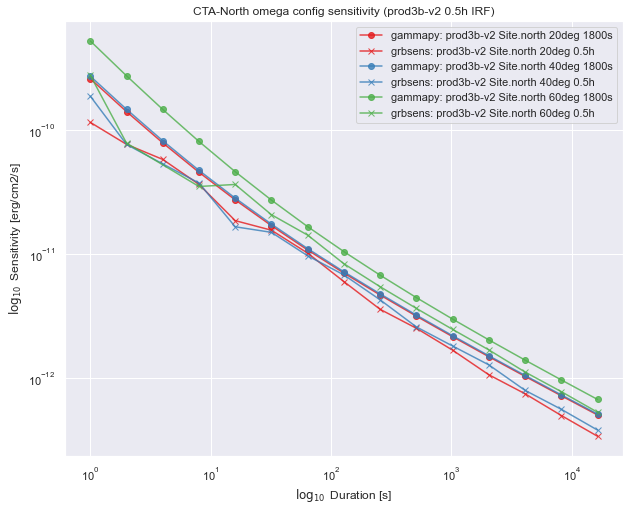

In [162]:
site = "north"
configuration = "omega"
version = "prod3b-v2"

irfs = [
    house.get_irf(
        site=site,
        configuration=configuration,
        zenith=z,
        duration=1800,
        azimuth="average",
        version=version,
    )
    for z in [20, 40, 60]
]

tables = plot_sensitivity(irfs, site, configuration, version)

## Investigate values in tables

Processing IRF: prod3b-v2 Site.south 20deg 1800s:   0%|          | 0/15 [00:00<?, ?it/s]

Processing IRF: prod3b-v2 Site.south 60deg 1800s: 100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


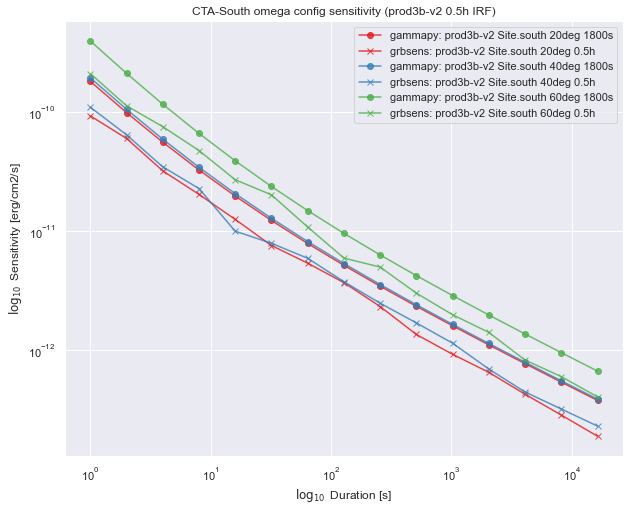

In [163]:
site = "south"
configuration = "omega"
version = "prod3b-v2"

irfs = [
    house.get_irf(
        site=site,
        configuration=configuration,
        zenith=z,
        duration=1800,
        azimuth="average",
        version=version,
    )
    for z in [20, 40, 60]
]

tables = plot_sensitivity(irfs, site, configuration, version)

In [164]:
combined_df = pd.concat(
    [
        pd.DataFrame.from_dict(table, orient="index").T.assign(
            duration=duration, zenith=zenith
        )
        for zenith, durations in tables.items()
        for duration, table in durations.items()
    ],
    ignore_index=True,
)

In [165]:
combined_df.to_csv("~/Downloads/cta_sensitivity.csv", index=False)

In [166]:
combined_df

,energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion,duration,zenith
0,0.547723,0.547723,0.03,10.0,0.0,8.182427,0.147753,significance,1,20
1,0.547723,0.547723,0.03,10.0,0.0,8.928152,0.295506,significance,2,20
2,0.547723,0.547723,0.03,10.0,0.0,10.058425,0.591012,significance,4,20
3,0.547723,0.547723,0.03,10.0,0.0,11.729666,1.182023,significance,8,20
4,0.547723,0.547723,0.03,10.0,0.0,14.153962,2.364047,significance,16,20
5,0.547723,0.547723,0.03,10.0,0.0,17.625705,4.728094,significance,32,20
6,0.547723,0.547723,0.03,10.0,0.0,22.560552,9.456187,significance,64,20
7,0.547723,0.547723,0.03,10.0,0.0,29.54941,18.912374,significance,128,20
8,0.547723,0.547723,0.03,10.0,0.0,39.432633,37.824749,significance,256,20
9,0.547723,0.547723,0.03,10.0,0.0,53.403199,75.649498,significance,512,20
